Let's create a prediction and evaluation without relying exclusively on previously written code.

Snippets from other notebooks will still be used here.

In [2]:
# Some fairly standard modules
import os, csv, lzma
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import descartes
from itertools import product
from collections import Counter

# The geopandas module does not come standard with anaconda,
# so you'll need to run the anaconda prompt as an administrator
# and install it via "conda install -c conda-forge geopandas".
# That installation will include pyproj and shapely automatically.
# These are useful modules for plotting geospatial data.
import geopandas as gpd
import pyproj
import shapely.geometry

# These modules are useful for tracking where modules are
# imported from, e.g., to check we're using our local edited
# versions of open_cp scripts.
import sys
import inspect
import importlib

# In order to use our local edited versions of open_cp
# scripts, we insert the parent directory of the current
# file ("..") at the start of our sys.path here.
sys.path.insert(0, os.path.abspath(".."))

# Elements from PredictCode's custom "open_cp" package
import open_cp
import open_cp.geometry
import open_cp.plot
import open_cp.sources.chicago as chicago
import open_cp.retrohotspot as retro

Our goal for now is to train a predictor on 2 months of Chicago data and then make a prediction for the next month of data, which we will then evaluate. Let's divide this into sub-goals:
* Load Chicago data
    * Just select THEFT for now, I think
    * Display map of data points and grid
* Create predictor
    * Depending on method, different parameters need to be selected/determined
        * Pure naive: just do counts, no parameters
        * Naive Gaussian: determine bandwidth (1000m chosen in Matt's code maybe?)
        * Retrospective hotspotting: determine space bandwidth and time bandwidth (Knox statistic)
    * Also need to select sampling rate per cell, and whether sampling is random or deterministic
* Generate output evaluation on subsequent 1 month of Chicago data
    * Grid of training crimes laid on risk-color cells
    * Grid of training crimes laid on increasing 5% area coverage
    * Grid of test crimes laid on risk-color cells
    * Grid of test crimes laid on increasing 5% area coverage
    * Line chart of coverage vs crime encountered, 0%-50%, compare random (average?) and oracle

First let's load the Chicago data

In [3]:
# Declare location of data directory for Chicago data
# We use our custom data path here; replace as necessary
datadir = os.path.join("..", "..", "Data")
chicago.set_data_directory(datadir)

In [4]:
# Obtain polygon shapely object for South side
ss_polygon = chicago.get_side("South")

# Obtain GeoDataFrame with polygon's geometry
#  and with CRS epsg:2790
ss_frame = gpd.GeoDataFrame({"name":["South Side"]})
ss_frame.geometry = [ss_polygon]
ss_frame.crs = {"init":"epsg:2790"}

In [5]:
# Obtain Chicago burglary data for the South Side
#points = chicago.default_burglary_data()
datafilepath = os.path.join(datadir, "chicago.csv")

points_theft = chicago.load(datafilepath, {"THEFT"})

start_train = np.datetime64("2018-03-01")
end_train = np.datetime64("2018-05-01")
start_test = np.datetime64("2018-05-01")
end_test = np.datetime64("2018-06-01")

points_theft_train = points_theft[(points_theft.timestamps >= start_train) 
                & (points_theft.timestamps <= end_train)]

points_theft_train_ss = open_cp.geometry.intersect_timed_points(points_theft_train,
                                                                ss_polygon)

# View initial features of the data
print("Number of timestamps: " + str(len(points_theft_train_ss.timestamps)))
print("Earliest time: " + str(points_theft_train_ss.time_range[0]))
print("Latest time: " + str(points_theft_train_ss.time_range[1]))


Number of timestamps: 999
Earliest time: 2018-03-01T00:00:00.000
Latest time: 2018-04-30T23:15:00.000


In [7]:
# Get masked grid

grid_250 = open_cp.data.Grid(xsize=250, ysize=250, xoffset=0, yoffset=0)
masked_grid_ss_250 = open_cp.geometry.mask_grid_by_intersection(ss_polygon, grid_250)

print("Total number of cells in region:", masked_grid_ss_250.xextent * masked_grid_ss_250.yextent)
print("Number of cells which intersect geometry:", np.sum(~masked_grid_ss_250.mask))

print(masked_grid_ss_250)

Total number of cells in region: 2058
Number of cells which intersect geometry: 961
MaskedGrid(offset=(355500,564500), size=250x250, mask region=42x49)


<class 'matplotlib.axes._subplots.AxesSubplot'>


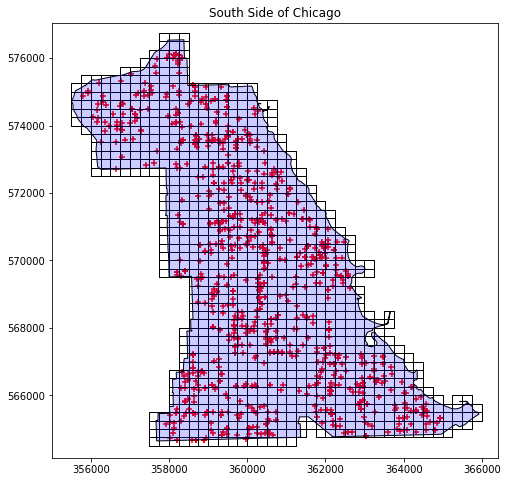

In [9]:
# View the South Side polygon, with 250x250-cell overlay
fig, ax  = plt.subplots(figsize=(8,8))

print(type(ax))

ax.add_patch(descartes.PolygonPatch(ss_polygon, fc="none", ec="Black"))
ax.add_patch(descartes.PolygonPatch(ss_polygon, fc="Blue", ec="none", alpha=0.2))
ax.scatter(points_theft_train_ss.xcoords,
           points_theft_train_ss.ycoords,
           marker="+", color="red")

xmin, ymin, xmax, ymax = ss_polygon.bounds
# Set the axes to have a buffer of 500 around the polygon
ax.set(xlim=[xmin-500,xmax+500], ylim=[ymin-500,ymax+500])

pc = open_cp.plot.patches_from_grid(masked_grid_ss_250)
ax.add_collection(matplotlib.collections.PatchCollection(pc, facecolor="None", edgecolor="black"))
ax.set_title("South Side of Chicago")
None

In [10]:
import open_cp.retrohotspot as retro
importlib.reload(open_cp.predictors)

rhs_pred = retro.RetroHotSpot()
rhs_pred.data = points_theft_train_ss
rhs_pred.weight = retro.Quartic(bandwidth = 1000)
rhs_risk = rhs_pred.predict()
rhs_grid_risk = open_cp.predictors.grid_prediction(rhs_risk, masked_grid_ss_250)


Calling prediction.to_matrix(42,49)
self.samples: 12
self.cell_width and height: 250,250
Done creating matrix.
Creating GridPredictionArray...


Text(0.5, 1.0, 'Continuous retrohotspotting prediction')

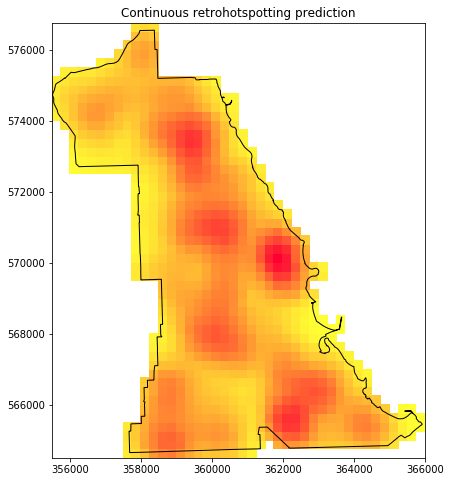

In [11]:
# Heat-like color mapping
_cdict = {'red':   [(0.0,  1.0, 1.0),
                   (1.0,  1.0, 1.0)],
         'green': [(0.0,  1.0, 1.0),
                   (1.0,  0.0, 0.0)],
         'blue':  [(0.0,  0.2, 0.2),
                   (1.0,  0.2, 0.2)]}
yellow_to_red = matplotlib.colors.LinearSegmentedColormap("yellow_to_red", _cdict)


fig, ax  = plt.subplots(figsize=(8,8))

ax.set_aspect(1)
ax.add_patch(descartes.PolygonPatch(ss_polygon, fc="none", ec="Black"))

ax.pcolormesh(*rhs_grid_risk.mesh_data(), rhs_grid_risk.intensity_matrix, cmap=yellow_to_red)
ax.set_title("Continuous retrohotspotting prediction")


In [12]:
print(type(rhs_grid_risk))
print(rhs_grid_risk.xextent)
print(rhs_grid_risk.yextent)
print(type(rhs_grid_risk.grid_risk(20,20)))
print(rhs_grid_risk.grid_risk)

rhs_grid_risk_matrix = rhs_grid_risk.intensity_matrix
print(type(rhs_grid_risk_matrix))


<class 'open_cp.predictors.GridPredictionArray'>
42
49
<class 'numpy.ndarray'>
<bound method GridPredictionArray.grid_risk of GridPredictionArray(offset=(355500,564500), size=250x250, risk intensity size=42x49)>
<class 'numpy.ma.core.MaskedArray'>


In [13]:
a = rhs_grid_risk_matrix
a[np.arange(np.shape(a)[0])[:,np.newaxis], np.argsort(a)]

masked_array(
  data=[[2.2490796933861548, 3.835532710874475, 6.138352009495104, ...,
         --, --, --],
        [3.6148240365520254, 4.5267988454967565, 4.862605969993435, ...,
         --, --, --],
        [1.109942185807937, 4.112939204060045, 5.3949436220988405, ...,
         --, --, --],
        ...,
        [10.427612481015476, 15.843386553134762, 16.55593834831652, ...,
         --, --, --],
        [11.223706260026455, 12.404373721263509, 13.838704455052293, ...,
         --, --, --],
        [6.078834089902923, 6.196972408193486, 7.569633457395983, ...,
         --, --, --]],
  mask=[[False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]],
  fill_value=1e+20)

In [52]:
# Ok I have been unable to find a way to use numpy
# to obtain a list of coordinates sorted by their
# values, so I'll just write it myself.
# I'll also factor in skipping over masked cells.

from itertools import product

cellcoord_risk_dict = dict()
print(type(masked_grid_ss_250))

print(rhs_grid_risk_matrix.shape)

cellcoordlist = product(*(range(x) for x in rhs_grid_risk_matrix.shape))

for cellcoords in cellcoordlist:
    if not rhs_grid_risk_matrix.mask[cellcoords[0]][cellcoords[1]]:
        cellcoord_risk_dict[cellcoords] = rhs_grid_risk_matrix[cellcoords[0]][cellcoords[1]]

print(len(cellcoord_risk_dict))

cells_sorted = sorted(cellcoord_risk_dict.items(), key=lambda x: x[1], reverse=True)

print(cells_sorted[:5])
print(cells_sorted[-5:])

<class 'open_cp.data.MaskedGrid'>
(49, 42)
961
[((22, 25), 50.76297435228806), ((21, 25), 47.12931993730657), ((22, 26), 46.06748524631819), ((23, 25), 45.9631191217485), ((21, 26), 45.29562721658173)]
[((14, 31), 0.06396214292520516), ((14, 32), 0.03880459958463527), ((14, 30), 0.03735609263288776), ((15, 30), 0.025179967440396276), ((15, 32), 0.0)]


In [16]:
# This maps cells to which 5% percentile they belong to
# This could be helpful for a color mapping,
# but isn't actually necessary for evaluating crime coverage

coverage_start = 0
coverage_end = 0.5
coverage_step = 0.05
step_ctr = 0
num_cells = len(cells_sorted)
cellcoord_covstep_dict = dict()
for ind, cell in enumerate(cells_sorted):
    coverage_pct = ind/num_cells
    if coverage_pct < coverage_start \
    or coverage_pct > coverage_end:
        cellcoord_covstep_dict[cell[0]] = -1
    cellcoord_covstep_dict[cell[0]] = np.floor((ind/num_cells)/coverage_step)

for cell in cells_sorted:
    print(cell, cellcoord_covstep_dict[cell[0]])


((22, 25), 50.76297435228806) 0.0
((21, 25), 47.12931993730657) 0.0
((22, 26), 46.06748524631819) 0.0
((23, 25), 45.9631191217485) 0.0
((21, 26), 45.29562721658173) 0.0
((22, 24), 45.10602346515979) 0.0
((23, 24), 42.9883612272408) 0.0
((23, 26), 42.143479799414656) 0.0
((4, 26), 41.224701988004185) 0.0
((21, 24), 41.20876510573997) 0.0
((4, 27), 41.20562388908494) 0.0
((35, 15), 40.89151729579178) 0.0
((36, 15), 40.06495019411449) 0.0
((3, 26), 39.99684935554198) 0.0
((20, 25), 39.537848195612874) 0.0
((35, 16), 39.535201809222905) 0.0
((5, 27), 39.16047881319435) 0.0
((3, 27), 39.14646630534117) 0.0
((36, 16), 38.79292110014283) 0.0
((20, 26), 38.64941755251258) 0.0
((34, 15), 37.7684868523561) 0.0
((24, 25), 37.49143084294787) 0.0
((5, 26), 37.45349311279716) 0.0
((26, 18), 37.263050725612096) 0.0
((25, 18), 37.26171102568445) 0.0
((25, 19), 37.25309331629328) 0.0
((34, 16), 37.06314664691288) 0.0
((35, 14), 37.016073090920315) 0.0
((36, 14), 36.77267472935149) 0.0
((4, 25), 36.3978

((31, 22), 10.91509195739932) 13.0
((3, 9), 10.869646598316686) 14.0
((8, 23), 10.854842299285442) 14.0
((3, 21), 10.854575508320144) 14.0
((1, 31), 10.806255078676662) 14.0
((41, 3), 10.777627702426166) 14.0
((2, 21), 10.773727666908256) 14.0
((9, 22), 10.74545939218047) 14.0
((2, 9), 10.715547760399131) 14.0
((22, 12), 10.677956376415688) 14.0
((6, 23), 10.64259063783612) 14.0
((11, 29), 10.625917128229519) 14.0
((7, 18), 10.625833621803478) 14.0
((7, 23), 10.580678215308488) 14.0
((20, 11), 10.578567858851885) 14.0
((31, 12), 10.577216589118814) 14.0
((36, 6), 10.509343165148033) 14.0
((1, 32), 10.448867471056937) 14.0
((26, 12), 10.442842644712243) 14.0
((34, 10), 10.42887066160237) 14.0
((5, 20), 10.428425231040835) 14.0
((46, 8), 10.427612481015476) 14.0
((43, 7), 10.424083442579727) 14.0
((7, 34), 10.41769337720551) 14.0
((24, 28), 10.416866669858212) 14.0
((16, 24), 10.384893896729354) 14.0
((18, 28), 10.323224966655582) 14.0
((5, 37), 10.32002481936672) 14.0
((42, 5), 10.31444

<class 'matplotlib.axes._subplots.AxesSubplot'>


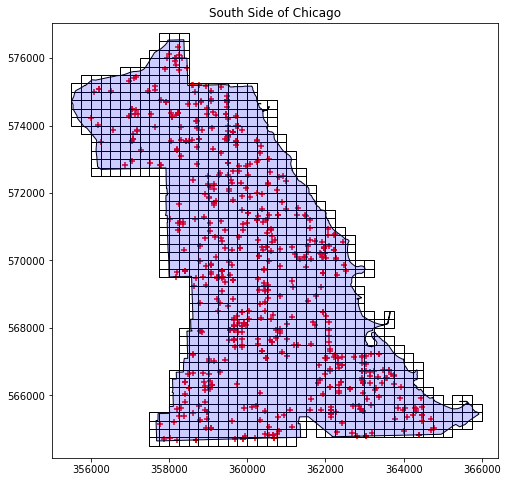

In [35]:
# Determine counts of crime in each cell in test data

points_theft_test = points_theft[(points_theft.timestamps >= start_test) 
                & (points_theft.timestamps <= end_test)]

points_theft_test_ss = open_cp.geometry.intersect_timed_points(points_theft_test,
                                                                ss_polygon)

# View the South Side polygon, with 250x250-cell overlay
fig, ax  = plt.subplots(figsize=(8,8))

print(type(ax))

ax.add_patch(descartes.PolygonPatch(ss_polygon, fc="none", ec="Black"))
ax.add_patch(descartes.PolygonPatch(ss_polygon, fc="Blue", ec="none", alpha=0.2))
ax.scatter(points_theft_test_ss.xcoords,
           points_theft_test_ss.ycoords,
           marker="+", color="red")

xmin, ymin, xmax, ymax = ss_polygon.bounds
# Set the axes to have a buffer of 500 around the polygon
ax.set(xlim=[xmin-500,xmax+500], ylim=[ymin-500,ymax+500])

pc = open_cp.plot.patches_from_grid(masked_grid_ss_250)
ax.add_collection(matplotlib.collections.PatchCollection(pc, facecolor="None", edgecolor="black"))
ax.set_title("South Side of Chicago")
None

In [54]:
# Let's map each crime to a cell, even though
# there's probably an easy built in way to do this already

# Get coordinates of times in test data
xcoords, ycoords = points_theft_test_ss.xcoords, points_theft_test_ss.ycoords
# Convert coordinates into corresponding grid indices for
# the cells that contain them
xgridinds = np.floor((xcoords - masked_grid_ss_250.xoffset) / masked_grid_ss_250.xsize).astype(np.int)
ygridinds = np.floor((ycoords - masked_grid_ss_250.yoffset) / masked_grid_ss_250.ysize).astype(np.int)

# Count the number of crimes per cell
# Make sure to do (y,x) instead of (x,y) because cells are (row,col)!!!
from collections import Counter
cells_testcrime_ctr = Counter(zip(ygridinds, xgridinds))


In [55]:
print(rhs_grid_risk_matrix.mask.shape)

cellinds = [x[0] for x in cells_sorted]
sorted([x for x in cells_testcrime_ctr if x not in cellinds])


(49, 42)


[]

In [57]:
crime_hit_runtotal = 0
crime_hit_rates = []
for c in cells_sorted:
    crime_hit_runtotal += cells_testcrime_ctr[c[0]]
    crime_hit_rates.append(crime_hit_runtotal)

#print(cells_sorted[0:5])
#print(cells_testcrime_ctr[cells_sorted[0]])
#print(crime_hit_rates)

In [72]:
#cells_sorted_test = (x[0] for x in cells_testcrime_ctr.most_common())
cells_sorted_test = sorted([x[0] for x in cells_sorted], 
                           key=cells_testcrime_ctr.__getitem__, 
                           reverse=True)
print(type(cells_sorted_test))
print(cells_sorted_test[:5])
print(cells_sorted_test[-5:])

crime_hit_runtotal_oracle = 0
crime_hit_rates_oracle = []
for c in cells_sorted_test:
    crime_hit_runtotal_oracle += cells_testcrime_ctr[c]
    crime_hit_rates_oracle.append(crime_hit_runtotal_oracle)
print(crime_hit_rates_oracle)
print(len(crime_hit_rates_oracle))
t = [crime_hit_rates_oracle[x+1]-crime_hit_rates_oracle[x] for x in range(len(crime_hit_rates_oracle)-1)]
print(t)
print(Counter(t))

<class 'list'>
[(3, 26), (22, 25), (7, 29), (36, 16), (39, 10)]
[(14, 31), (14, 32), (14, 30), (15, 30), (15, 32)]
[12, 21, 30, 38, 46, 53, 60, 66, 72, 78, 84, 90, 96, 101, 106, 111, 116, 120, 124, 128, 132, 136, 140, 144, 148, 152, 156, 160, 164, 168, 172, 176, 180, 184, 188, 192, 195, 198, 201, 204, 207, 210, 213, 216, 219, 222, 225, 228, 231, 234, 237, 240, 243, 246, 249, 252, 255, 258, 261, 264, 267, 270, 273, 276, 279, 281, 283, 285, 287, 289, 291, 293, 295, 297, 299, 301, 303, 305, 307, 309, 311, 313, 315, 317, 319, 321, 323, 325, 327, 329, 331, 333, 335, 337, 339, 341, 343, 345, 347, 349, 351, 353, 355, 357, 359, 361, 363, 365, 367, 369, 371, 373, 375, 377, 379, 381, 383, 385, 387, 389, 391, 393, 395, 397, 399, 401, 403, 405, 407, 409, 411, 413, 415, 417, 419, 421, 423, 425, 427, 429, 431, 433, 435, 437, 439, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 47

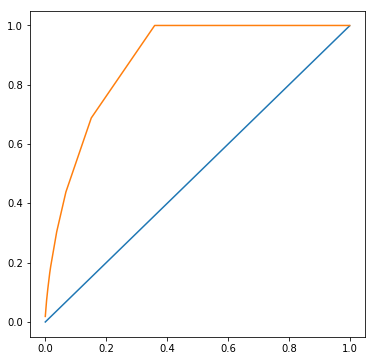

In [73]:
# Make chart

fig, ax = plt.subplots(figsize=(6,6))
#ax.plot(np.asarray(range(num_cells))/num_cells, 
#        np.asarray(crime_hit_rates)/crime_hit_rates[-1])
ax.plot(np.asarray(range(num_cells))/num_cells, 
        np.asarray(range(num_cells))/num_cells)
ax.plot(np.asarray(range(num_cells))/num_cells, 
        np.asarray(crime_hit_rates_oracle)/crime_hit_rates[-1])



None